In [1]:
import numpy as np
import pandas as pd
import MetaTrader5 as mt5
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
import matplotlib.pyplot as plt
from itertools import combinations
import backtrader as bt
import seaborn as sns

In [2]:
PAIRS = ["EURUSD", "GBPUSD", "USDJPY", "AUDUSD", "NZDUSD", "USDCAD", "USDCHF", "EURJPY", "GBPJPY", "NZDJPY", "AUDJPY", "CADJPY", "CHFJPY"]
TIMEFRAME = mt5.TIMEFRAME_H1
BARS = 1000

# Initialize MetaTrader 5 connection
if not mt5.initialize():
    print("MetaTrader 5 initialization failed")
    mt5.shutdown()

# Fetch the data for each pair
symbol_data = {}
for symbol in PAIRS:
    rates = mt5.copy_rates_from_pos(symbol, TIMEFRAME, 0, BARS)
    symbol_data[symbol] = pd.DataFrame(rates)
    symbol_data[symbol]['time'] = pd.to_datetime(symbol_data[symbol]['time'], unit='s')

# Shut down MT5 after data fetching
mt5.shutdown()

True

In [7]:
symbol_pairs = list(combinations(PAIRS, 2))

# Initialize an empty list to store cointegrated pairs
cointegrated_pairs = []
cointegration_results = []

# Function to test cointegration
def test_cointegration(data1, data2):
    coint_result = coint(data1, data2)
    return coint_result[1]  # Return the p-value of the test

# Test each pair for cointegration
for pair in symbol_pairs:
    symbol1, symbol2 = pair
    data1 = symbol_data[symbol1]['close']
    data2 = symbol_data[symbol2]['close']

    p_value = test_cointegration(data1, data2)
    cointegration_results.append((symbol1, symbol2, p_value))
    if p_value < 0.05:  # 95% confidence level
        cointegrated_pairs.append(pair)
        print(f'Cointegrated Pair Found: {symbol1} and {symbol2} with p-value {p_value:.4f}')

# Store the cointegration results in a DataFrame
cointegration_df = pd.DataFrame(cointegration_results, columns=['Symbol-1', 'Symbol-2', 'P-value'])
cointegration_df

Cointegrated Pair Found: NZDUSD and USDCAD with p-value 0.0239


,Symbol-1,Symbol-2,P-value
0,EURUSD,GBPUSD,0.787587
1,EURUSD,USDJPY,0.769658
2,EURUSD,AUDUSD,0.508108
3,EURUSD,NZDUSD,0.122258
4,EURUSD,USDCAD,0.146869
...,...,...,...
73,NZDJPY,CADJPY,0.801084
74,NZDJPY,CHFJPY,0.385297
75,AUDJPY,CADJPY,0.585210
76,AUDJPY,CHFJPY,0.203534


Mean Reverting Pair: NZDUSD and USDCAD


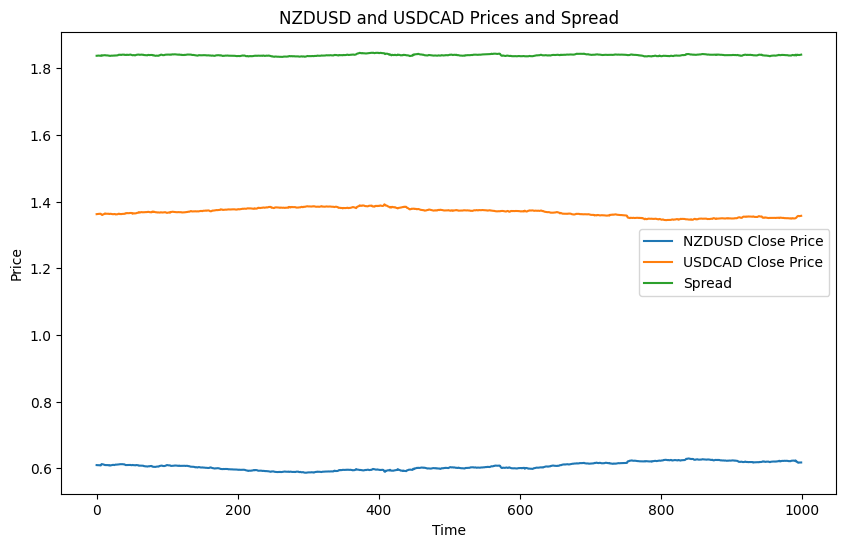

In [4]:
# Function to compute the spread between two symbols and calculate hedge ratio
def compute_spread(symbol1, symbol2):
    data1 = symbol_data[symbol1]['close']
    data2 = symbol_data[symbol2]['close']
    
    # Compute hedge ratio using OLS regression
    model = sm.OLS(data1, sm.add_constant(data2))
    result = model.fit()
    hedge_ratio = result.params[1]
    
    # Calculate the spread
    spread = data1 - hedge_ratio * data2
    return data1, data2, spread, hedge_ratio  # Return the close prices, spread, and hedge ratio

# Function to calculate Z-scores for the spread
def calculate_z_score(spread, window=30):
    spread_mean = spread.rolling(window=window).mean()
    spread_std = spread.rolling(window=window).std()
    z_score = (spread - spread_mean) / spread_std
    return z_score

# Plot function to chart symbol1, symbol2, and spread prices
def plot_spread_chart(spread_df, symbol1, symbol2):
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=spread_df['symbol1_close'], label=f'{symbol1} Close Price')
    sns.lineplot(data=spread_df['symbol2_close'], label=f'{symbol2} Close Price')
    sns.lineplot(data=spread_df['spread'], label='Spread')
    plt.title(f'{symbol1} and {symbol2} Prices and Spread')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

# Lists to store results
mean_reverting_pairs = []
mean_reversion_results = []
spread_dict = {}

# Iterate over cointegrated pairs
for pair in cointegrated_pairs:
    symbol1, symbol2 = pair
    # Get the close prices and spread
    symbol1_close, symbol2_close, spread, hedge_ratio = compute_spread(symbol1, symbol2)
    
    # Create a DataFrame with the desired columns
    spread_df = pd.DataFrame({
        'symbol1': symbol1,
        'symbol2': symbol2,
        'symbol1_close': symbol1_close,
        'symbol2_close': symbol2_close,
        'spread': spread,
        'hedge_ratio': hedge_ratio
    })
    spread_dict[pair] = spread_df  # Store the DataFrame in spread_dict

    # Augmented Dickey-Fuller test to check for stationarity (mean-reverting)
    adf_result = adfuller(spread)
    p_value = adf_result[1]
    mean_reversion_results.append((symbol1, symbol2, p_value))
    
    # Check if the p-value indicates stationarity (mean-reversion)
    if p_value < 0.05:  # 95% confidence level
        mean_reverting_pairs.append(pair)
        print(f'Mean Reverting Pair: {symbol1} and {symbol2}')
        
        # Plot the spread chart for mean-reverting pairs
        plot_spread_chart(spread_df, symbol1, symbol2)

# Convert the results to a DataFrame for analysis
mean_reversion_df = pd.DataFrame(mean_reversion_results, columns=['Symbol-1', 'Symbol-2', 'P-value'])

In [5]:
class PairTradingStrategy(bt.Strategy):
    params = (
        ('symbol1', ''),
        ('symbol2', ''),
        ('lookback', 50),
        ('threshold', 2),  # Z-score threshold for trade signals
    )

    def __init__(self):
        self.symbol1_close = self.datas[0].close
        self.symbol2_close = self.datas[1].close

        # Calculate spread and Z-score
        self.spread = self.symbol1_close - self.symbol2_close
        self.mean_spread = bt.indicators.SimpleMovingAverage(self.spread, period=self.params.lookback)
        self.spread_std = bt.indicators.StandardDeviation(self.spread, period=self.params.lookback)

    def next(self):
        # Calculate Z-score of the spread
        z_score = (self.spread[0] - self.mean_spread[0]) / self.spread_std[0]

        # Long symbol1, short symbol2 if spread is below -threshold (too low)
        if z_score < -self.params.threshold:
            if not self.position:
                self.buy(data=self.datas[0])  # Long symbol1
                self.sell(data=self.datas[1])  # Short symbol2

        # Short symbol1, long symbol2 if spread is above threshold (too high)
        elif z_score > self.params.threshold:
            if not self.position:
                self.sell(data=self.datas[0])  # Short symbol1
                self.buy(data=self.datas[1])  # Long symbol2

In [6]:
if mean_reverting_pairs:
    cerebro = bt.Cerebro()
    
    # Add data for both symbols (NZDUSD and USDCAD as an example)
    pair1_data = bt.feeds.PandasData(dataname=symbol_data['NZDUSD'])
    pair2_data = bt.feeds.PandasData(dataname=symbol_data['USDCAD'])
    
    cerebro.adddata(pair1_data)
    cerebro.adddata(pair2_data)
    
    # Add the pair trading strategy
    cerebro.addstrategy(PairTradingStrategy, symbol1='NZDUSD', symbol2='USDCAD')
    
    # Run the backtest
    cerebro.run()
    cerebro.plot()

AttributeError: 'int' object has no attribute 'to_pydatetime'